<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Landlab Landslide Component Demonstration with a Synthetic Grid

**Two Hydrologic Forcing Options (Depth to Groundwater and Recharge) are compared using default parameters and Uniform Distribution**


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

## 0.  Software Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

### Import Landlab and other Python utilities

In [1]:
import numpy as np

from landlab import RasterModelGrid
from landlab.components.landslides import LandslideProbability
import landlab.plot.landslides.plot_landslides as pl
import tests.components.landslides.test_landslide_probability as test

#temporary code for Ronda Binder/JH demo test in Binder before Pull Request
#import LandslideProbability
#import plot_landslides as pl
#import test_landslide_probability as test

### Landslide Component Definitions
#### key variables and functions in `test_landslide_probability.py`


`grid` is the Landlab raster model grid initialization

`ls_grid` is a `grid`  with landslide parameters added to nodes
The input fields (see input_var_names) on the node are initialized in this step.

`ls_grid` is input to `LandslideProbability()` to add model parameters to define the size of the Monte Carlo method, statistical distribution (four options), and hydrologic forcings (two options: recharge OR depth to water table) for the landslide model. A distribution of hydrologic forcing is used to calculate the probability of lansdlides in the Factor of Safety equation; the mean hydrologic forcing  per node has been added as a model output (in addition to relative wetness, probability of saturation, and probability of failure). 

`ls_prob` is the output of `LandslideProbability()` and considered a model instance (or model initialization).

`ls_prob` is the input to `calculate_landslide_probability()`. Model results are saved in the same input dictionary by adding output fields.

`ls_prob` is both the input and output of  `calculate_landslide_probability()` and should be saved, or recalculated with a clean `ls_grid` to ensure variables are saved as expected (not overwritten) for each change of parameters and model calculation.

The output fields (see output_var_names) on the node are initialized to zero, and contain the model results. 

## 1. Create a synthetic grid with landslide unit_default data fields

**1.1 Use the unit test to build a synthetic grid investigate features of the grid.** 

The total number of nodes is limited to 20, which is fast for computers and easy for humans.

In [2]:
shape = (5, 4)
spacing = (10e0, 10e0)
coordinates = (0.0, 0.0)
grid = RasterModelGrid(shape,spacing,coordinates)

print('The synthetic grid `grid` is a Landlab RasterModelGrid: {value}. '.format(value=grid))
grid

The synthetic grid `grid` is a Landlab RasterModelGrid: <xarray.Dataset>
Dimensions:         (Two: 2, cell: 6, face: 17, link: 31, max_patch_links: 4, node: 20, patch: 12)
Coordinates:
  * node            (node) int32 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Dimensions without coordinates: Two, cell, face, link, max_patch_links, patch
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 0.0 10.0 ... 40.0 40.0 40.0 40.0
    x_of_node       (node) float64 0.0 10.0 20.0 30.0 0.0 ... 0.0 10.0 20.0 30.0
    nodes_at_link   (link, Two) int32 0 1 1 2 2 3 0 4 ... 19 16 17 17 18 18 19
    links_at_patch  (patch, max_patch_links) int32 4 7 3 0 5 ... 22 27 30 26 23
    node_at_cell    (cell) int32 5 6 9 10 13 14
    nodes_at_face   (face, Two) int32 1 5 2 6 4 5 5 6 ... 14 14 15 13 17 14 18. 


RasterModelGrid((5, 4), xy_spacing=(10.0, 10.0), xy_of_lower_left=(0.0, 0.0))

We can see how many core nodes we use in the unit grid (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'.  The spacing between nodes is equivalent to the grid cell edge length.  Nodes are the centroid of each grid.

In [3]:
gridnum = grid.number_of_nodes
print('The synthetic grid has {value} total grid cells (nodes), including the boundary nodes.'.format(value=grid.number_of_nodes)) 
print('The synthetic grid has {value} m grid cell size (space between nodes).'.format(value=grid.dx)) 
grid_cnum = grid.number_of_core_nodes
print("Core nodes are the center of a Landlab model grid.")
print("Landslide calculations are made only on {value} core nodes.".format(value=grid_cnum))
print("This is the array of Landlab node values used to index the core nodes (dictionary key)")
grid.core_nodes

The synthetic grid has 20 total grid cells (nodes), including the boundary nodes.
The synthetic grid has 10.0 m grid cell size (space between nodes).
Core nodes are the center of a Landlab model grid.
Landslide calculations are made only on 6 core nodes.
This is the array of Landlab node values used to index the core nodes (dictionary key)


array([ 5,  6,  9, 10, 13, 14])

In [4]:
#grid?

To read more documentation about this dataset type:

Use `RasterModelGrid?` OR `unitgrid?` OR uncomment cell above.

<hr>
<small>For more Introduction to Landlab’s Gridding Library, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/grid.html">https://landlab.readthedocs.io/en/latest/user_guide/grid.html</a></small>
<hr>

The Landlab grid variable we input to `LandslideProbability` is a `RasterModelGrid` data type we have named `grid`, it has inputs and outputs on each node, but only calculated on the core nodes.

In [5]:
 sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

## Write a function to build a landslide component unit grid

In [6]:
def build_landslide_unitgrid(shape,spacing,coordinates,forcing):
    # 1. Build a Landlab grid
    grid = RasterModelGrid(shape,spacing,coordinates)
    gridnum = grid.number_of_nodes
    # 2. Get range of default landslide parameters
    unit_default_value = test.calc_unit_default_value()
    # 3. Distribute and Add the parameters to each node on a Landlab grid
    ls_grid = test.landslide_pars_ongrid(grid, gridnum, unit_default_value)
    # 4. Calculate default depth and recharge forcing range as a function of relative wetness,
    # given the default unit grid inputs (Recharge = f(rw, T, a, slope); Depth = f(rw, hs))
    relative_wetness = 0.75
    Default_R, Default_D=test.scenario_unit_explorer(relative_wetness,ls_grid)
    # 5. Distribute and Add the parameters to a Landlab grid that will be linked to the landslide model instance
    if forcing == 'depth':
        ls_prob = LandslideProbability(
        ls_grid,
        number_of_iterations=25,
        groundwater__depth_distribution="uniform",
        groundwater__depth_min_value=Default_D[0],
        groundwater__depth_max_value=Default_D[1]
        )
    else: 
        ls_prob = LandslideProbability(
        ls_grid,
        number_of_iterations=25,
        groundwater__recharge_distribution="uniform",
        groundwater__depth_min_value=Default_R[0],
        groundwater__depth_max_value=Default_R[1]
        )
    ## sometimes a grid format is easier to work with, other times, it's easier to maintain the linked 
    ## model instance with a new grid for each model test
    return ls_prob, ls_grid

In [7]:
ls_prob, ls_grid = build_landslide_unitgrid(shape,spacing,coordinates,'depth')

In [8]:
print("Landslide Component Input Variables are on the grid/node")
ls_prob.input_var_names

Landslide Component Input Variables are on the grid/node


('soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area')

In [9]:
print("Landslide Component Output Variables at each grid/node")
ls_prob.output_var_names

Landslide Component Output Variables at each grid/node


('landslide__probability_of_failure',
 'soil__mean_recharge',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation')

In [10]:
LandslideProbability.var_help('soil__mean_watertable_depth')

name: soil__mean_watertable_depth
description:
  Mean depth to water table from surface to perched water table within
  the soil layer
units: m
unit agnostic: False
at: node
intent: out


In [11]:
LandslideProbability.var_help('soil__mean_recharge')

name: soil__mean_recharge
description:
  Mean recharge to the soil layer
units: mm/day
unit agnostic: False
at: node
intent: out


**1.2 Investigate the range of default parameters on each node of the grid.**

The test builds a grid with a default synthetic range of min/max parameter inputs used in the unit test. The function `get_default_nodevalues()` creates a variable from the default values.  Since we haven't calculated the landslide probability yet, only initialized the inputs, the output values are initialized to zeros. 

In [12]:
test_unit_defaultpars=test.get_default_nodevalues()
test_unit_defaultpars

{'topographic__slope': (0.1, 0.8),
 'topographic__specific_contributing_area': (10, 100),
 'soil__transmissivity': (0.1, 10),
 'soil__mode_total_cohesion': (30, 900),
 'soil__minimum_total_cohesion': (28, 898),
 'soil__maximum_total_cohesion': (32, 902),
 'soil__internal_friction_angle': (26, 37),
 'soil__thickness': (0.1, 1),
 'soil__density': (1999, 2001),
 'soil__saturated_hydraulic_conductivity': (0.1, 100.0),
 'landslide__probability_of_failure': (0, 1),
 'soil__mean_relative_wetness': (0, 1),
 'soil__mean_watertable_depth': (0, 1000),
 'soil__mean_recharge': (0, 1000),
 'soil__probability_of_saturation': (0, 1)}

Run the next cells to view DEFAULT soil parameters on the node.(optional)

In [13]:
value_list = ['topographic__slope']
pl.print_list_nodevalues(ls_prob, value_list)

topographic__slope (Min, Max) range of (0.1122925705333193,0.7480403039112747) values on node:
All topographic__slope default value initialized for each node:
[ 0.7480403   0.72716988  0.68776065  0.68015717  0.67050114  0.61065173
  0.6028036   0.57932975  0.57409705  0.53597005  0.50366754  0.43871955
  0.32205438  0.29514249  0.25984415  0.25510452  0.23846819  0.23009768
  0.21061147  0.11229257]



In [14]:
#value_list = ['soil__transmissivity']
#pl.print_list_nodevalues(ls_prob, value_list)

Run the next cells to CHANGE DEFAULT soil parameters on the node.(optional)

In [15]:
##Transmissivity
#grid.at_node["soil__transmissivity"] = np.sort(np.random.uniform(0.1,100,gridnum).astype(float))    
#reverse order: lowest Transmissivity value are in upper right of synthethic grid
#grid['node']['soil__transmissivity'] = grid['node']['soil__transmissivity'][::-1]  
       

Add a field for dimensions of recharge in millimeters. Default input is in meters.

In [16]:
recharge_mm_per_m=1000
ls_grid.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * ls_grid.at_node['soil__mean_recharge']

In [17]:
value_list = ['soil__transmissivity']
pl.print_list_nodevalues(ls_prob, value_list)

soil__transmissivity (Min, Max) range of (0.5518624867352111,8.999222060358967) values on node:
All soil__transmissivity default value initialized for each node:
[ 8.99922206  8.13153568  8.11660316  8.05056567  7.53529099  7.19276421
  7.03753653  6.11827834  5.84955765  4.93376387  4.89080833  4.58014162
  4.03705543  3.41412464  3.06914378  1.89468106  1.7611151   1.58686495
  0.67226364  0.55186249]



In [18]:
value_list = ['soil__saturated_hydraulic_conductivity','soil__transmissivity','soil__thickness']
pl.print_list_nodevalues(ls_prob, value_list)

soil__saturated_hydraulic_conductivity (Min, Max) range of (0.5534901364479368,89.82593850454361) values on node:
All soil__saturated_hydraulic_conductivity default value initialized for each node:
[ 89.8259385   45.05702575  27.89616029  26.475766    23.62890858
  22.5331548   21.54680286  15.08590645  13.78997005  11.45045771
  10.45120463   8.62421051   7.43883036   4.96522286   3.86427838
   2.35089539   2.17385213   1.7354691    0.73004832   0.55349014]

soil__transmissivity (Min, Max) range of (0.5518624867352111,8.999222060358967) values on node:
All soil__transmissivity default value initialized for each node:
[ 8.99922206  8.13153568  8.11660316  8.05056567  7.53529099  7.19276421
  7.03753653  6.11827834  5.84955765  4.93376387  4.89080833  4.58014162
  4.03705543  3.41412464  3.06914378  1.89468106  1.7611151   1.58686495
  0.67226364  0.55186249]

soil__thickness (Min, Max) range of (0.10018511590506526,0.9970592977082279) values on node:
All soil__thickness default value i

In [19]:
#value_list = ['soil__minimum_total_cohesion','soil__maximum_total_cohesion','soil__mode_total_cohesion']
#pl.print_list_nodevalues(ls_grid, value_list)

### 1.13 Make Landslide Unit Grid Maps

The plot function `plot_landslide_4variables()` uses the Landlab plotting function `imshow_grid()` and creates subplots for any 4 variables on a Landlab grid.

Let's see what one of these fields (slope) looks like on the grid of 10 x 10 m grid cells. 

In [20]:
ls_grid.at_node['topographic__slope']


array([ 0.7480403 ,  0.72716988,  0.68776065,  0.68015717,  0.67050114,
        0.61065173,  0.6028036 ,  0.57932975,  0.57409705,  0.53597005,
        0.50366754,  0.43871955,  0.32205438,  0.29514249,  0.25984415,
        0.25510452,  0.23846819,  0.23009768,  0.21061147,  0.11229257])

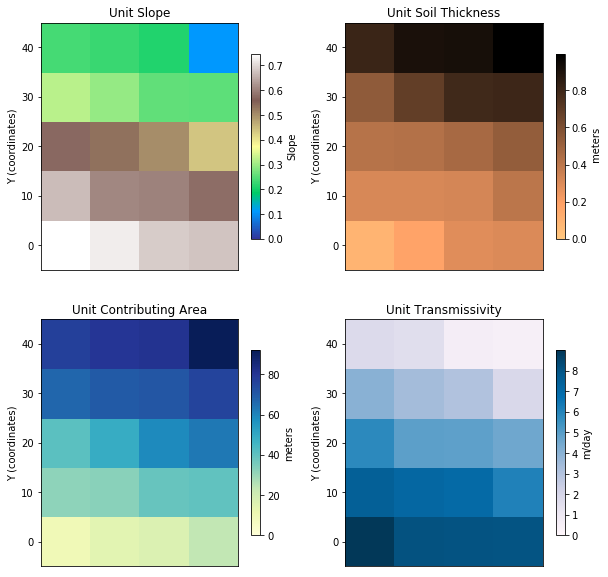

In [21]:
fields=['topographic__slope','soil__thickness','topographic__specific_contributing_area','soil__transmissivity']
maxval=[ls_grid.at_node['topographic__slope'].max(),
        ls_grid.at_node['soil__thickness'].max(),
        ls_grid.at_node['topographic__specific_contributing_area'].max(),
        ls_grid.at_node['soil__transmissivity'].max(),]
subtitles=['Unit Slope','Unit Soil Thickness','Unit Contributing Area','Unit Transmissivity']
colors=['terrain','copper_r','YlGnBu','PuBu']
scalelabel=['Slope',' meters','meters','m/day']

pl.plot_landslide_4variables([221,222,223,224],
                          ls_grid,ls_grid,ls_grid,ls_grid,
                          fields,maxval,
                          subtitles,colors,scalelabel)

Can't get enough nitty gritty landslide component details?  

Uncomment the box below to review ALL the details of what each variable represents.  
(Close the window with the upper right [x] after viewing.)

In [22]:
#?LandslideProbability

 ### 2.3. Recharge and Depth Options - 'uniform' distribution 

In this option, we'll apply a uniform distribution of recharge and depth based on minimum and maximum recharge and depth values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and depth and instantiating the component.


In [23]:
LS_prob1_r,grid_r1 = build_landslide_unitgrid(shape,spacing,coordinates,'recharge')
LS_prob1_d,grid_d1 = build_landslide_unitgrid(shape,spacing,coordinates,'depth')

print("Recharge Hydrologic Forcing")
LS_prob1_r.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob1_r,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob1_r)
print("Depth Hydrologic Forcing")
LS_prob1_d.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob1_d,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob1_d)

print("Unit test core node 6 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][5]))
print("Unit test core node 10 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][9]))

Recharge Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.8   0.92  0.    0.    1.    0.56  0.
  0.    0.52  0.    0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.8   0.92  0.    0.    1.    0.56  0.
  0.    0.52  0.    0.    0.    0.    0.    0.  ]

Depth Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.96  0.84  0.    0.    1.    0.72  0.
  0.    0.    0.04  0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.96  0.84  0.    0.    1.    0.72  0.
  0.

In [24]:
print("Uniform Recharge Synthetic core node 6 = {value}".format(value=LS_prob1_r.grid.at_node["landslide__probability_of_failure"][5]))
print("Uniform Recharge Synthetic  core node 10 = {value}".format(value=LS_prob1_r.grid.at_node["landslide__probability_of_failure"][9]))
print("Uniform Depth Synthetic  core node 6 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][5]))
print("Uniform Depth Synthetic  core node 10 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][9]))

Uniform Recharge Synthetic core node 6 = 0.8
Uniform Recharge Synthetic  core node 10 = 1.0
Uniform Depth Synthetic  core node 6 = 0.96
Uniform Depth Synthetic  core node 10 = 1.0


In [25]:
#Default relative wetness calculated with unitgrid input values 
#this is used to calculate the max and min Depth and Recharge for plotting
rel_wet = 0.75


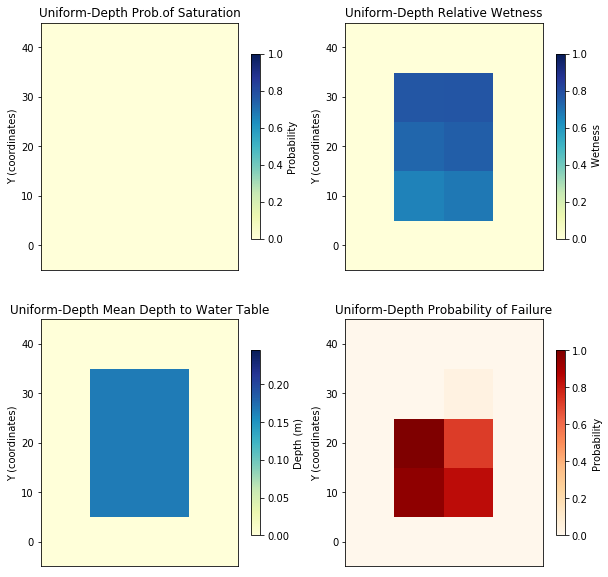

In [26]:
#Main Plot inputs
pgrid = LS_prob1_d.grid
[unit_R,unit_D]=test.scenario_unit_explorer(rel_wet,pgrid) #set max
#Landslide plot inputs for Uniform Depth forcing
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, unit_D[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Depth to Water Table','Probability of Failure']
smashtitle=subtitle
ptitle = "Uniform-Depth %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

### Uniform-Recharge
Recharge outputs are in meters (m), here we convert the recharge to mm/day and add to the grid. 

In [27]:
print(unit_R)
recharge_mm_per_m=1000
LS_prob1_r.grid.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * LS_prob1_r.grid.at_node['soil__mean_recharge']

[0.21158308226351061, 429.95313818623936, 88.514077976873821, 110.11583638971329]


In [28]:
LS_prob1_d.grid.at_node['soil__mean_recharge']

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [29]:
LS_prob1_r.grid.at_node['soil__mean_recharge']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.07907663,  0.07907663,  0.        ,  0.        ,  0.07907663,
        0.07907663,  0.        ,  0.        ,  0.07907663,  0.07907663,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

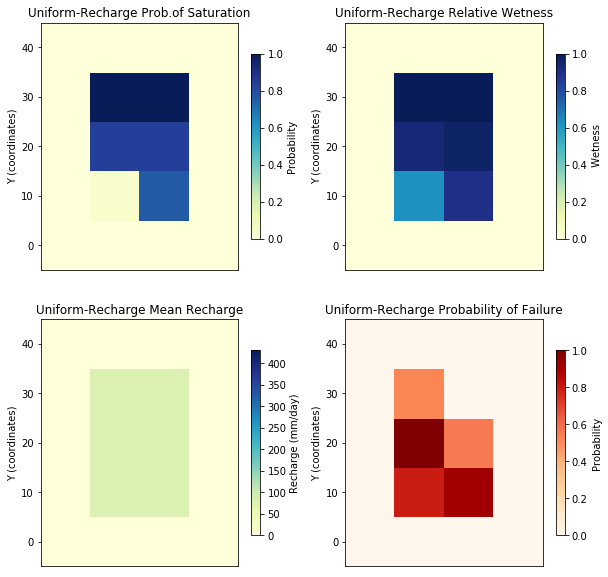

In [30]:
pgrid = LS_prob1_r.grid
[unit_R,unit_D]=test.scenario_unit_explorer(rel_wet,pgrid)
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge_mm','landslide__probability_of_failure']
maxval=[1,1, unit_R[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probability of Failure']
smashtitle=subtitle
ptitle = "Uniform-Recharge %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

## Citing Landlab Landslide Component

**If you use any portion of Landlab, you must cite the following papers:**

Hobley, D. E. J., Adams, J. M., Nudurupati, S. S., Hutton, E. W. H., Gasparini, N. M., Istanbulluoglu, E. and Tucker, G. E., 2017, Creative computing with Landlab: an open-source toolkit for building, coupling, and exploring two-dimensional numerical models of Earth-surface dynamics, Earth Surface Dynamics, 5, p 21-46, 10.5194/esurf-5-21-2017.

Barnhart, K. R., Hutton, E. W. H., Tucker, G. E., Gasparini, N. M., Istanbulluoglu, E., Hobley, D. E. J., Lyons, N. J., Mouchene, M., Nudurupati, S. S., Adams, J. M., and Bandaragoda, C.: Short communication: Landlab v2.0: A software package for Earth surface dynamics, Earth Surf. Dynam. Discuss., https://doi.org/10.5194/esurf-2020-12, in review, 2020.
                
**If you use any portion of the Landlab Landslide Component, you must cite the following paper:**
Strauch, R., Istanbulluoglu, E., Nudurupati, S.S., Bandaragoda, C., Gasparini, N.M. and Tucker, G.E., 2018. A hydroclimatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6(1), pp.49-49.

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:150px;padding:20px">   


The development of this Notebook has been made possible by the Landlab project funded by the National Science Foundation (OAC 1450338 to N. Gasparini, OAC 1450409 to G. Tucker, OAC 1450412 to E. Istanbulluoglu).

We acknowledge that this research takes place in the ancestral homelands of Tribes, Bands, and First Nations, including most notably the Upper Skagit Indian Tribe, Sauk-Suiattle Indian Tribe, Swinomish Indian Tribal Community, Samish Indian Nation, Nooksack Tribe, Lummi Nation, Stó:lō Nation, Nlaka’pamux Nation, Colville Confederated Tribes, Syilx/Okanagan Nation.  The University of Washington acknowledges the Coast Salish peoples of this land, the land which touches the shared waters of all tribes and bands within the Suquamish, Tulalip and Muckleshoot nations. 


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>